<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#First-steps" data-toc-modified-id="First-steps-1">First steps</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1">Imports</a></span></li><li><span><a href="#Creating-the-environment" data-toc-modified-id="Creating-the-environment-1.2">Creating the environment</a></span></li><li><span><a href="#Learning-to-use-the-environment" data-toc-modified-id="Learning-to-use-the-environment-1.3">Learning to use the environment</a></span></li><li><span><a href="#Playing-and-recording-the-games" data-toc-modified-id="Playing-and-recording-the-games-1.4">Playing and recording the games</a></span></li><li><span><a href="#Learning-from-recorded-games" data-toc-modified-id="Learning-from-recorded-games-1.5">Learning from recorded games</a></span><ul class="toc-item"><li><span><a href="#Preparing-the-data" data-toc-modified-id="Preparing-the-data-1.5.1">Preparing the data</a></span></li><li><span><a href="#Creating-the-model" data-toc-modified-id="Creating-the-model-1.5.2">Creating the model</a></span><ul class="toc-item"><li><span><a href="#Problems-with-conda-environment" data-toc-modified-id="Problems-with-conda-environment-1.5.2.1">Problems with conda environment</a></span></li><li><span><a href="#Building-the-model" data-toc-modified-id="Building-the-model-1.5.2.2">Building the model</a></span></li></ul></li><li><span><a href="#Train" data-toc-modified-id="Train-1.5.3">Train</a></span></li></ul></li><li><span><a href="#Visualizing-agent-play" data-toc-modified-id="Visualizing-agent-play-1.6">Visualizing agent play</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.7">Summary</a></span></li></ul></li></ul></div>

# First steps

On this notebook I want to learn how to use the arena on python and how to train a model.

## Imports

In [48]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm_notebook as tqdm
import glob
from sklearn.preprocessing import OneHotEncoder

import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Input, Concatenate, Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from animalai.envs import UnityEnvironment
from animalai.envs.arena_config import ArenaConfig

## Creating the environment

In [3]:
env = UnityEnvironment(
    file_name='/media/guillermo/Data/Dropbox/02 Inteligencia Artificial/31_animalai/AnimalAI-Olympics/env/AnimalAI.x86_64',   # Path to the environment
    worker_id=0,                # Unique ID for running the environment (used for connection)
    seed=0,                     # The random seed 
    docker_training=False,      # Whether or not you are training inside a docker
    n_arenas=1,                 # Number of arenas in your environment
    play=False,                 # Set to False for training
    inference=False,            # Set to true to watch your agent in action
    resolution=None             # Int: resolution of the agent's square camera (in [4,512], default 84)
)

INFO:mlagents.envs:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of Training Brains : 1


In [4]:
arena_config = ArenaConfig('/media/guillermo/Data/Dropbox/02 Inteligencia Artificial/31_animalai/AnimalAI-Olympics/examples/configs/1-Food.yaml')
env.reset(arenas_configurations=arena_config, train_mode=True)

{'Learner': <animalai.envs.brain.BrainInfo at 0x7f2fa18172e8>}

In [120]:
arena_config = ArenaConfig('/media/guillermo/Data/Dropbox/02 Inteligencia Artificial/31_animalai/AnimalAI-Olympics/examples/configs/1-Food_small.yaml')
env.reset(arenas_configurations=arena_config, train_mode=True)

{'Learner': <animalai.envs.brain.BrainInfo at 0x7f2e5049f4a8>}

## Learning to use the environment

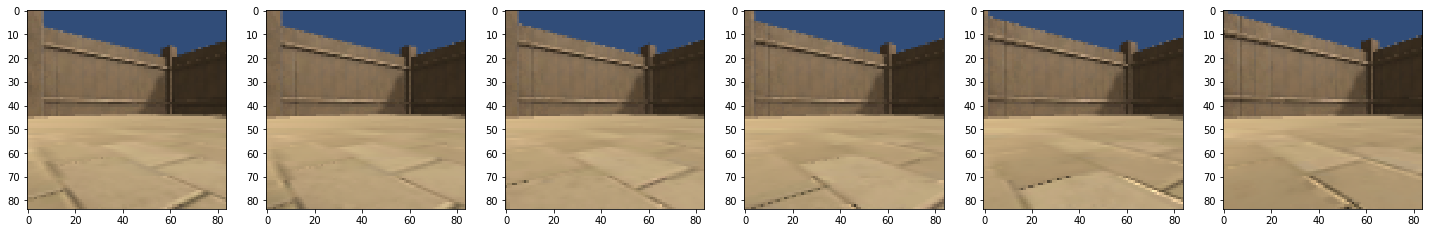

In [4]:
plt.figure(figsize=(25, 5))
for i in range(6):
    plt.subplot(1, 6, i+1)
    info = env.step(vector_action=[1, 0])
    plt.imshow(info['Learner'].visual_observations[0][0]);

In [5]:
env.reset()
for _ in tqdm(range(1000)):
    info = env.step(vector_action=[0, 1])

With this configuration the environment is capable of doing about 300 iterations per second, that is quite fast.

## Playing and recording the games

I will always turn right (press d) by default. When playing depending on the start orientation it didn't felt natural to do that, sometimes I think is better to turn left. In just 10 minutes I'm able to play more than 50 games, so this is a very fast process.

In [5]:
def get_action_from_keyboard():
    key_to_action = {
        ord('d'): [0, 1],
        ord('a'): [0, 2],
        ord('w'): [1, 0],
        ord('s'): [2, 0],
        ord('o'): None,
    }
    while 1:
        key = cv2.waitKey()
        if key in key_to_action:
            action = key_to_action[key]
            break
        else:
            print('Unknown key pressed')
    return action

In [6]:
class LevelStorage():
    def __init__(self):
        self.frame = []
        self.speed = []
        self.previous_action = []
        self.action = []
    
    def add(self, frame, speed, previous_action, action):
        self.frame.append(frame)
        self.speed.append(speed)
        self.previous_action.append(previous_action)
        self.action.append(action)
        
    def save(self, path):
        np.savez(path, frame=self.frame, speed=self.speed, previous_action=self.previous_action, action=self.action)

In [133]:
info = env.reset()['Learner']
level_idx = 114
n_steps = 0
cv2.namedWindow('img', cv2.WINDOW_NORMAL)
level_storage = LevelStorage()

while 1:
    frame = info.visual_observations[0][0]
    speed = info.vector_observations.round(2)
    previous_action = info.previous_vector_actions
    
    cv2.imshow('img', frame[:, :, [2, 1, 0]])
    msg = 'Level: %i     n_steps: %i   Reward: %.2f   Speed: %s Text observations: %s' % (
        level_idx,
        n_steps,
        info.rewards[0],
        speed,
        info.text_observations[0])
    cv2.displayOverlay('img', msg)
    action = get_action_from_keyboard()
    if action is None:
        break
        
    level_storage.add(frame, speed, previous_action, action)
    
    info = env.step(vector_action=action)['Learner']
    n_steps += 1
    is_level_ended = info.max_reached[0] or info.local_done[0]
    if is_level_ended:
        level_idx += 1
        n_steps = 0
        level_storage.save('/media/guillermo/Data/Kaggle/animalai/gameplay/1_food/%03d.npz' % level_idx)
        level_storage = LevelStorage()
        
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

## Learning from recorded games

I have recorded 53 games that use less than 500 MB of memory. That is about 10 MB per game.

I want to train a model that learns to play like me. As input I will use:

* pixels
* speed
* last action

I will process the pixels with a lenet-like network and finally use a perceptron to predict the probability over each action.

For training I will leave some of the games out for validation.

### Preparing the data

In [122]:
game_filepaths = sorted(glob.glob('/media/guillermo/Data/Kaggle/animalai/gameplay/1_food/*.npz'))
np.random.seed(7)
np.random.shuffle(game_filepaths)
len(game_filepaths)

150

In [73]:
def load_games_data(game_filepaths):
    data = [np.load(game_filepath) for game_filepath in tqdm(game_filepaths, desc='Loading recorded games')]
    ohe = OneHotEncoder(categories=[range(3)], sparse=False)
    previous_action = np.concatenate([game['previous_action'] for game in data], axis=0)[:, 0]
    ohe.fit(previous_action[:, 1:2])
    previous_action = [ohe.transform(previous_action[:, 0:1]), ohe.transform(previous_action[:, 1:2])]
    previous_action = np.concatenate(previous_action, axis=1)
    model_input = {
        'frame': np.concatenate([game['frame'] for game in data], axis=0),
        'speed': np.concatenate([game['speed'] for game in data], axis=0)[:, 0]/10,
        'previous_action': previous_action,
    }
    action = np.concatenate([game['action'] for game in data], axis=0)
    model_output = {
        'action_move': ohe.transform(action[:, 0:1]),
        'action_rotate': ohe.transform(action[:, 1:2]),
    }
    return model_input, model_output

In [24]:
model_input, model_output, data = load_games_data(game_filepaths)
input_keys = ['frame', 'speed', 'previous_action']
output_keys = ['action_move', 'action_rotate']
print('Inputs')
for key in input_keys:
    print('%s shape: %s' % (key, str(model_input[key].shape)))
print('Outputs')
for key in output_keys:
    print('%s shape: %s' % (key, str(model_output[key].shape)))


Inputs
frame shape: (3300, 84, 84, 3)
speed shape: (3300, 3)
previous_action shape: (3300, 6)
Outputs
action_move shape: (3300, 3)
action_rotate shape: (3300, 3)


In [123]:
train = load_games_data(game_filepaths[:-20])
val = load_games_data(game_filepaths[-20:])
print('Number of train samples: %i' % len(train[0]['frame']))
print('Number of validation samples: %i' % len(val[0]['frame']))


Number of train samples: 6447
Number of validation samples: 995


### Creating the model

The idea is to process the frame using a lenet like network and merge it later with speed and previous move to take a decision over the actions.

![](https://miro.medium.com/max/2625/1*1TI1aGBZ4dybR6__DI9dzA.png)

#### Problems with conda environment

There are inconsistencies between opencv, tensorflow-gpu and the environment requirements (numpy 1.14.5). Maybe I should create an environment for playing an another for training. However if I want to do reinforcement learning I need both in the environment.

Which are my requirements:
* python 3.6, this is required by animalai
* opencv 4.1.0 or higher, previous versions do not show the window
* tensorflow-gpu, needed to train
* numpy 1.14.5, is this really necessary?

I think the problem is that there are conflicts between them.

Ideas:
* I could try to create an environment from zero
* Why numpy 1.14.5 is needed?

Let's try to use a higher version of numpy on animalai. I can revert to other versions of the environment following the link below.

http://blog.rtwilson.com/conda-revisions-letting-you-rollback-to-a-previous-version-of-your-environment/

I have been able to remove numpy 1.14.5 and install numpy 1.16.1 and the environment runs.

I have created a new environment called animal that seems to be working. The steps were the following:

```
conda create -n animal python=3.6
conda activate animal
pip install animalai
pip uninstall numpy
conda install -c conda-forge tensorflow-gpu opencv==4.1.0
conda install jupyter ipywidgets
python -m ipykernel install --user --name $CONDA_DEFAULT_ENV --display-name "Python ($CONDA_DEFAULT_ENV)"
conda install pytest rope pylint tqdm pandas scikit-learn ipython ipykernel autopep8 matplotlib
```

#### Building the model

In [65]:
def build_model(conv_filters, mlp_units):
    frame = Input(shape=(84, 84, 3), name='frame')
    output = frame
    for n_filters in conv_filters:
        output = Conv2D(filters=n_filters, kernel_size=(3, 3), activation='relu')(output)
        output = MaxPool2D()(output)
    output = Flatten()(output)
    
    speed = Input(shape=(3), name='speed')
    previous_action = Input(shape=(6), name='previous_action')
    
    output = Concatenate()([output, speed, previous_action])
    
    for n_units in mlp_units:
        output = Dense(n_units, activation='relu')(output)
    
    action_move = Dense(3, activation='softmax', name='action_move')(output)
    action_rotate = Dense(3, activation='softmax', name='action_rotate')(output)
    
    model = Model(inputs=dict(frame=frame, speed=speed, previous_action=previous_action), outputs=[action_move, action_rotate])
    return model

In [68]:
model = build_model([8, 8, 16, 16], [16])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
frame (InputLayer)              [(None, 84, 84, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 82, 82, 8)    224         frame[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 41, 41, 8)    0           conv2d_24[0][0]                  
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 39, 39, 8)    584         max_pooling2d_24[0][0]           
____________________________________________________________________________________________

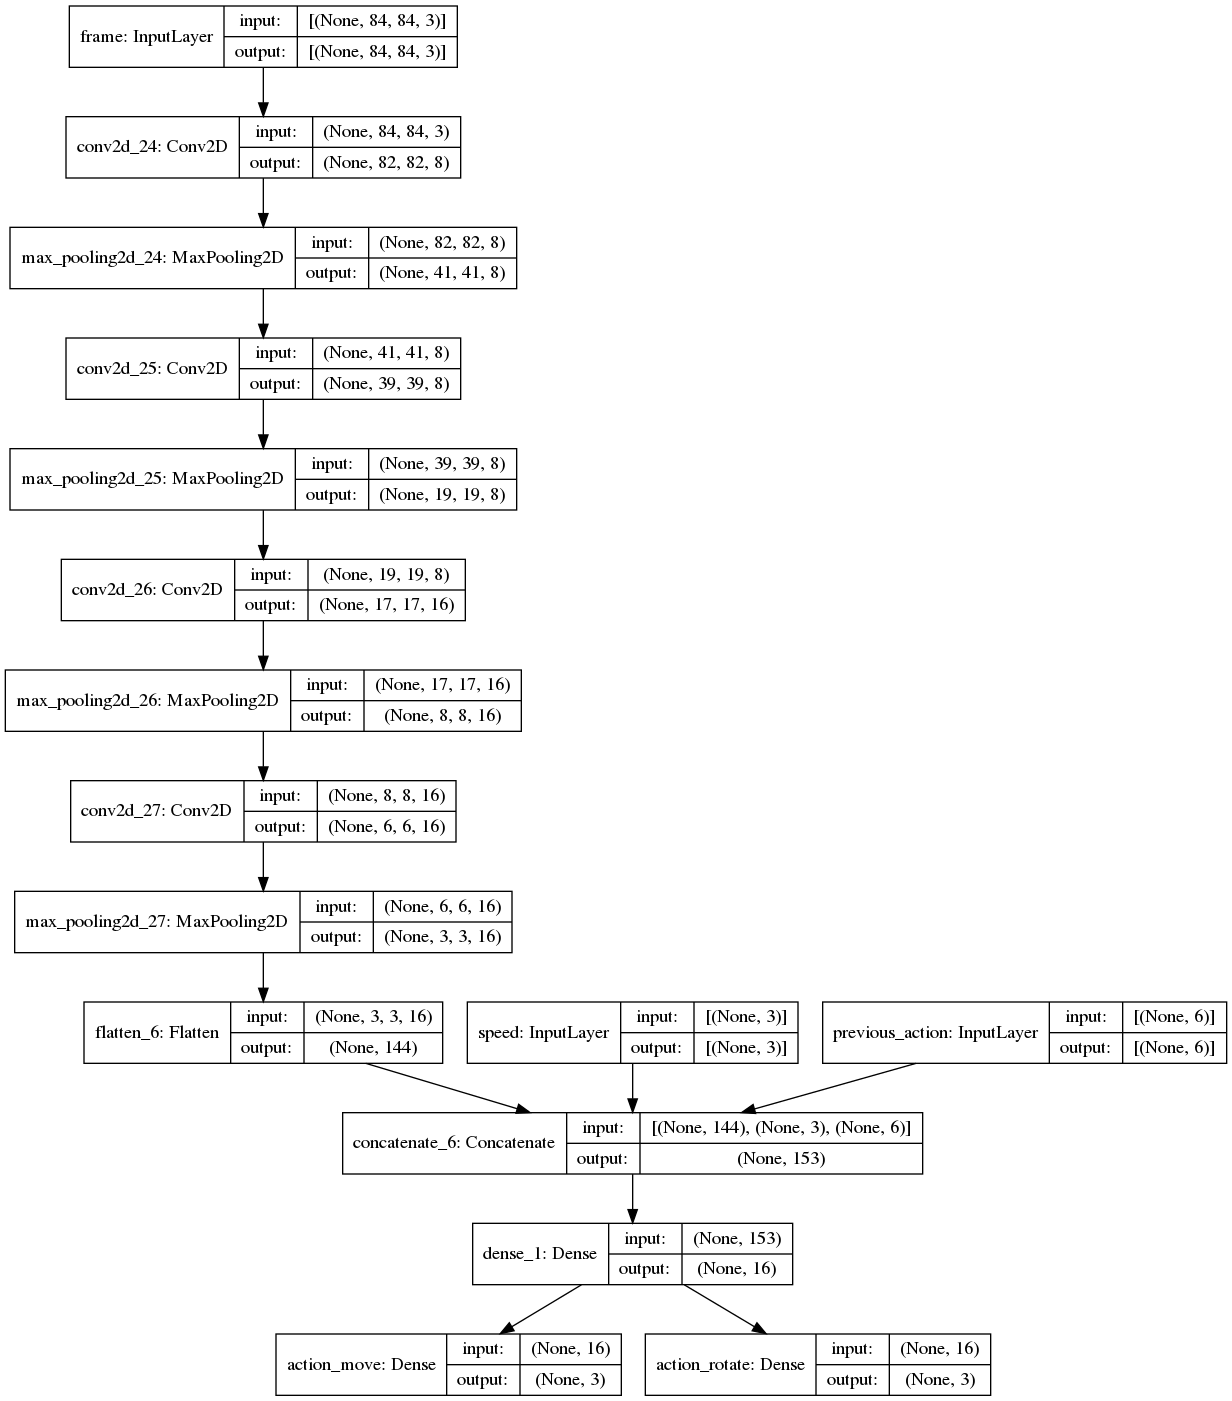

In [69]:
plot_model(model, show_shapes=True)

In [21]:
train[0]['frame'].shape

(2806, 84, 84, 3)

In [27]:
model.predict(train[0], batch_size=32, verbose=1)

2806/2806 [==============================] - 0s 93us/sample


[array([[0.3731478 , 0.30699477, 0.31985748],
        [0.35981053, 0.35984838, 0.28034103],
        [0.37141642, 0.3486689 , 0.2799147 ],
        ...,
        [0.40580714, 0.00190342, 0.5922895 ],
        [0.40458828, 0.00183663, 0.59357506],
        [0.39020362, 0.00169898, 0.60809743]], dtype=float32),
 array([[2.9629123e-01, 3.4093401e-01, 3.6277470e-01],
        [3.1343883e-01, 3.3088651e-01, 3.5567465e-01],
        [3.0650663e-01, 3.3603188e-01, 3.5746148e-01],
        ...,
        [6.7303479e-02, 8.5454324e-04, 9.3184197e-01],
        [6.7455359e-02, 8.0940087e-04, 9.3173522e-01],
        [6.8677425e-02, 7.7946781e-04, 9.3054312e-01]], dtype=float32)]

This is very fast, it should train very fast also.

### Train

In [124]:
model = build_model([8, 8, 16, 16], [16])

In [125]:
model.compile(Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [126]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='loss', patience=2, factor=0.7, verbose=1)
]

In [127]:
hist = model.fit(x=train[0], y=train[1], epochs=500, validation_data=val, callbacks=callbacks)

Train on 6447 samples, validate on 995 samples
Epoch 1/500
6447/6447 [==============================] - 2s 285us/sample - loss: 1.0102 - action_move_loss: 0.4349 - action_rotate_loss: 0.5745 - action_move_acc: 0.8604 - action_rotate_acc: 0.7721 - val_loss: 0.6366 - val_action_move_loss: 0.2596 - val_action_rotate_loss: 0.3689 - val_action_move_acc: 0.9226 - val_action_rotate_acc: 0.9196
Epoch 2/500
6447/6447 [==============================] - 1s 217us/sample - loss: 0.5573 - action_move_loss: 0.2497 - action_rotate_loss: 0.3067 - action_move_acc: 0.9215 - action_rotate_acc: 0.9184 - val_loss: 0.5294 - val_action_move_loss: 0.2338 - val_action_rotate_loss: 0.2836 - val_action_move_acc: 0.9186 - val_action_rotate_acc: 0.9236
Epoch 3/500
6447/6447 [==============================] - 1s 219us/sample - loss: 0.5020 - action_move_loss: 0.2353 - action_rotate_loss: 0.2671 - action_move_acc: 0.9248 - action_rotate_acc: 0.9237 - val_loss: 0.5052 - val_action_move_loss: 0.2375 - val_action_rotate

Epoch 25/500
6447/6447 [==============================] - 1s 222us/sample - loss: 0.2725 - action_move_loss: 0.1329 - action_rotate_loss: 0.1399 - action_move_acc: 0.9513 - action_rotate_acc: 0.9493 - val_loss: 0.3829 - val_action_move_loss: 0.1988 - val_action_rotate_loss: 0.2230 - val_action_move_acc: 0.9397 - val_action_rotate_acc: 0.9367
Epoch 26/500
6447/6447 [==============================] - 1s 205us/sample - loss: 0.2655 - action_move_loss: 0.1294 - action_rotate_loss: 0.1355 - action_move_acc: 0.9524 - action_rotate_acc: 0.9511 - val_loss: 0.4026 - val_action_move_loss: 0.1838 - val_action_rotate_loss: 0.2076 - val_action_move_acc: 0.9387 - val_action_rotate_acc: 0.9357
Epoch 27/500
6447/6447 [==============================] - 1s 212us/sample - loss: 0.2624 - action_move_loss: 0.1285 - action_rotate_loss: 0.1334 - action_move_acc: 0.9536 - action_rotate_acc: 0.9539 - val_loss: 0.4089 - val_action_move_loss: 0.1836 - val_action_rotate_loss: 0.2153 - val_action_move_acc: 0.9377 

In [128]:
def plot_hist(hist):
    plt.figure()
    keys = ['loss']
    for key in keys:
        plt.plot(hist[key], label=key)
        plt.plot(hist['val_%s' % key], label='val_%s' % key)
        plt.legend(loc=0)

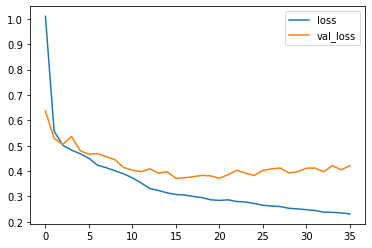

In [129]:
plot_hist(hist.history)

## Visualizing agent play

In [135]:
class Agent():
    def __init__(self, model):
        self._n_rotations = 0
        self.model = model

    def get_action_from_model(self, info):
        frame = info.visual_observations[0][0]
        speed = info.vector_observations.round(2)
        previous_action = info.previous_vector_actions[0]

        model_input = {
            'frame': np.expand_dims(frame, axis=0),
            'speed': speed/10,
        }
        previous_move, previous_rotate = np.zeros(3), np.zeros(3)
        previous_move[int(previous_action[0])] = 1
        previous_rotate[int(previous_action[1])] = 1
        previous_action = np.concatenate([previous_move, previous_rotate])
        model_input['previous_action'] = np.expand_dims(previous_action, axis=0)
        ret = self.model.predict(model_input, batch_size=1)
        action_move = ret[self.model.output_names.index('action_move')]
        action_rotate = ret[self.model.output_names.index('action_rotate')]
        action = [np.argmax(action_move), np.argmax(action_rotate)]
        if action == [0, 0]:
            action = [1, 0]
        if action[0] == 0:
            self._n_rotations += 1
        else:
            self._n_rotations = 0
        if self._n_rotations > 60:
            action = [1, 0]
        return action
    
    def reset(self):
        self._n_rotations = 0

In [138]:
info = env.reset()['Learner']
level_idx = 0
n_steps = 0
cv2.namedWindow('img', cv2.WINDOW_NORMAL)
agent = Agent(model)

while 1:
    frame = info.visual_observations[0][0]
    speed = info.vector_observations.round(2)
    previous_action = info.previous_vector_actions[0]
    
    cv2.imshow('img', frame[:, :, [2, 1, 0]])
    msg = 'Level: %i     n_steps: %i   Reward: %.2f   Speed: %s Text observations: %s' % (
        level_idx,
        n_steps,
        info.rewards[0],
        speed,
        info.text_observations[0])
    cv2.displayOverlay('img', msg)
    key = cv2.waitKey(1)
    if key == ord('o'):
        break
    action = agent.get_action_from_model(info)
    
    info = env.step(vector_action=action)['Learner']
    n_steps += 1
    is_level_ended = info.max_reached[0] or info.local_done[0]
    if is_level_ended:
        level_idx += 1
        n_steps = 0
        agent.reset()
        
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

In [137]:
model.save('model.hdf')

## Summary

I have trained a very simple model on recorded games. At first I recorded some random games but later I noticed that small goals were failing to be detected so I decided to play more matches with small goals.